## Feature Engineering & Model Testing

In [1]:
import pandas as pd
import numpy as np
from util.data_access import load_data
from util.preprocess import get_preprocessed_data, get_column_indices
from util.tracking import get_metrics
from util import columns
import lightgbm as lgb
from dotenv import load_dotenv
load_dotenv()
SEED = 42
import datetime

import os
import mlflow
mlflow.set_tracking_uri('http://35.246.127.179')


EXPERIMENT_NAME = 'Fraud Model Feature Engineering Loop'

try:
    EXPERIMENT_ID = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
except Exception as e:
    print(e)
    EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)

In [2]:
from src.util.preprocess import mean_category_amount_previous_step, train_test_split_by_step


df_raw = load_data()

#MAX_MERCHANT_TRANSACTIONS = get_max_group_count(df_raw['merchant'])
#MAX_CUSTOMER_TRANSACTIONS = get_max_group_count(df_raw['customer'])
#MAX_CATEGORY_TRANSACTIONS = get_max_group_count(df_raw['category'])
#
#moving_average_configs = {
#    'merchant': (MAX_MERCHANT_TRANSACTIONS,50,10,5,3),
#    'customer': (MAX_CUSTOMER_TRANSACTIONS,10,5),
#    'category': (MAX_CATEGORY_TRANSACTIONS,100,10),
#}
#
#max_transaction_map = {
#    'merchant': MAX_MERCHANT_TRANSACTIONS,
#    'customer': MAX_CUSTOMER_TRANSACTIONS,
#    'category': MAX_CATEGORY_TRANSACTIONS
#}
#
#for group, windows in moving_average_configs.items():
#    max_window = max(windows)
#    for window in windows:
#        w = 'total' if window == max_window else window
#        df_raw[f'{group}_amount_ma_{w}'] = get_rolling_mean_by_group(df_raw,'amount',group, window=window, min_periods=1)
#
#df_raw['transactions_completed'] = 1
#for group, max_transactions in max_transaction_map.items():
#    df_raw[f'{group}_amount_moving_max'] = get_rolling_max_by_group(df_raw, 'amount',group,window=max_transactions,min_periods=1)
#    df_raw[f'{group}_fraud_comitted_mean'] = get_rolling_mean_by_group_lag(df_raw,'amount',group,window=max_transactions,min_periods=1,period_shift=1)
#    if group != 'category':
#        df_raw[f'{group}_transaction_number'] = get_rolling_sum_by_group(df_raw, 'transactions_completed', group, window=max_transactions, min_periods=1)
#
### Amount transacted the day before
#df_raw['mean_category_amount_previous_step'] = mean_category_amount_previous_step(df_raw, 'category','step','amount')
df = get_preprocessed_data(df_raw)

X_train, X_valid, y_train, y_valid = train_test_split_by_step(
    data=df,
    step='step',
    target='fraud',
    train_size=0.8
)


In [3]:
#X_train = preprocess(X_train_raw, cat_columns, columns.DROP)
#X_valid = preprocess(X_valid_raw, cat_columns, columns.DROP)

In [4]:
train_data = X_train.loc[:,columns.MODEL]
valid_data = X_valid.loc[:,columns.MODEL]
_cat_columns_idx = get_column_indices(train_data,columns.CATEGORICAL)

params = {
    'max_depth': 5,
    'n_estimators' : 200,
    'num_leaves': 40,
}
model = lgb.LGBMClassifier(
    **params,
    random_state=SEED,
    n_jobs=-1
)
#_cat_columns_idx = [train_data.columns.get_loc(i) for i in _cat_columns]


from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [-1, 3, 5, 10, 20, 30],
    'n_estimators': [100, 150, 200],
    'scale_pos_weight': np.arange(1,100,10),
    'num_leaves': np.arange(2,100,10),
    'learning_rate': np.logspace(-1,-4,5)
}
grid_search = GridSearchCV(model,param_grid=param_grid,n_jobs=-1 )

#grid_search.fit(train_data, y_train, categorical_feature=_cat_columns_idx)
model.fit(train_data,y_train,categorical_feature=_cat_columns_idx)

/home/simontwo/zenml-competition/env/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMClassifier(max_depth=5, n_estimators=200, num_leaves=40, random_state=42)

In [5]:
with mlflow.start_run(experiment_id='3') as run:
    #mlflow.log_param('Columns', columns)
    mlflow.log_param('Train Data Dimension', train_data.shape)     
    mlflow.log_param('Train Target Bad Rate', y_train.mean())     
    mlflow.log_param('Valid Data Dimension', valid_data.shape)     
    mlflow.log_param('Valid Target Dimension', y_valid.mean())     

    mlflow.log_param('Model Type', model.__class__.__name__)
    y_pred_train = model.predict(train_data)
    y_pred_proba_train = model.predict(train_data)
    train_metrics = get_metrics(y_train,y_pred_train,y_pred_proba_train)

    #for key, val in grid_search.best_params_.items():
    #    mlflow.log_param(key,val)

    for key, val in params.items():
        mlflow.log_param(key,val)

    for key, val in train_metrics.items():
        mlflow.log_metric(f'Train {key}', val)

    y_pred_valid = model.predict(valid_data)
    y_pred_proba_valid = model.predict(valid_data)
    train_metrics = get_metrics(y_valid,y_pred_valid,y_pred_proba_valid)

    for key, val in train_metrics.items():
        mlflow.log_metric(f'Validation {key}', val)

In [6]:
import shap
explainer = shap.TreeExplainer(model)
explain_data = train_data.sample(frac=0.1)
shap_values = explainer.shap_values(explain_data)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


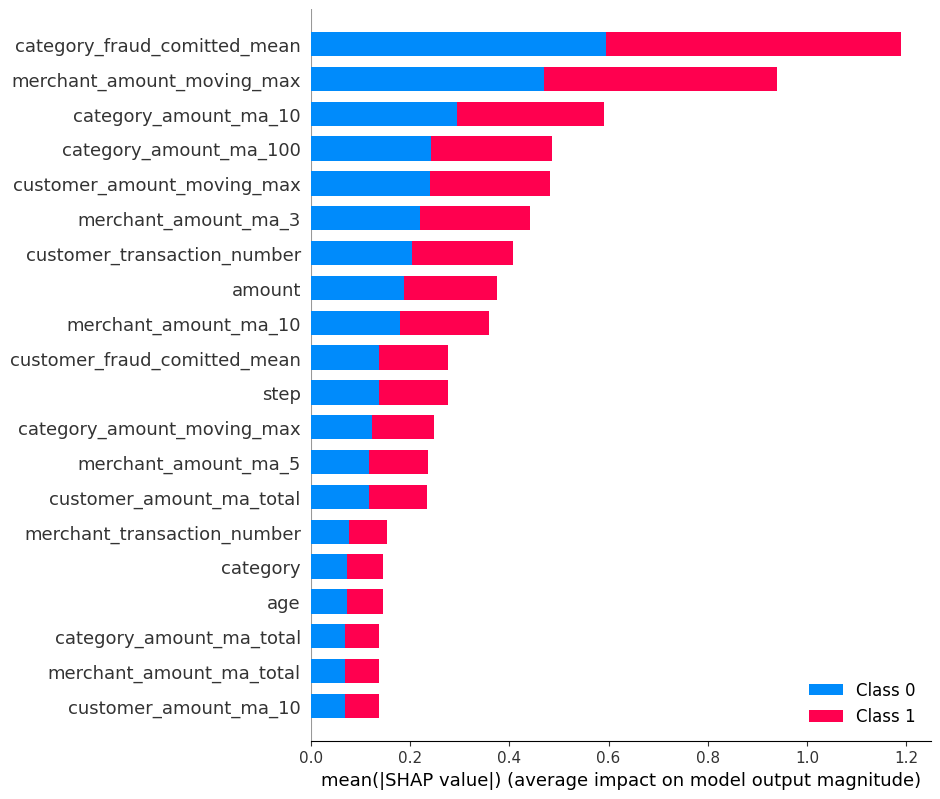

In [7]:
shap.summary_plot(shap_values, explain_data)

In [8]:
{
    col: f
    for col, f
    in zip(train_data.columns, model.feature_importances_)
}

{'customer_transaction_number': 314,
 'merchant_transaction_number': 189,
 'step': 295,
 'amount': 505,
 'merchant_amount_ma_total': 166,
 'merchant_amount_ma_50': 128,
 'merchant_amount_ma_10': 150,
 'merchant_amount_ma_5': 200,
 'merchant_amount_ma_3': 248,
 'merchant_amount_moving_max': 289,
 'customer_amount_ma_total': 214,
 'customer_amount_ma_10': 209,
 'customer_amount_ma_5': 316,
 'customer_amount_moving_max': 351,
 'category_amount_ma_total': 129,
 'category_amount_ma_100': 152,
 'category_amount_ma_10': 187,
 'category_amount_moving_max': 123,
 'mean_category_amount_previous_step': 163,
 'customer_fraud_comitted_mean': 292,
 'merchant_fraud_comitted_mean': 139,
 'category_fraud_comitted_mean': 95,
 'category': 90,
 'gender': 29,
 'age': 46}